# Artificial Intelligence for Robotics
* Path Smoothing (Non-cyclic path smoothing, cyclic path smoothing, constrained path smoothing)
* PID Control
* Twiddle Algorithm for parameter optimization

## Path Smoothing

In [1]:
# -----------
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

from copy import deepcopy

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print '['+ ', '.join('%.3f'%x for x in old) + \
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']'

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001):

    # Make a deep copy of path into newpath
    newpath = deepcopy(path)

    change = tolerance
    while change >= tolerance:
        change = 0
        for i in range(1,len(path) - 1):
            for j in range(len(path[0])):
                oldpath = newpath[i][j]
                newpath[i][j] += weight_data * (path[i][j] - newpath[i][j]) + weight_smooth * (newpath[i+1][j] + newpath[i-1][j] - 2 * newpath[i][j])
                change += abs(newpath[i][j] - oldpath) 
    return newpath

In [2]:
printpaths(path,smooth(path))

[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.021, 0.979]
[0.000, 2.000] -> [0.149, 1.851]
[1.000, 2.000] -> [1.021, 1.979]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.979, 2.021]
[4.000, 2.000] -> [3.851, 2.149]
[4.000, 3.000] -> [3.979, 3.021]
[4.000, 4.000] -> [4.000, 4.000]


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_paths(oldpath, newpath):
    #plt.rcParams.update({'figure.figsize': (len(oldpath)/2,len(oldpath)/2)})
    x = []
    y = []
    y_max = max(oldpath)[0]
    y_min = min(oldpath)[0]
    x_max = -1000
    x_min = 1000
    for i in range(len(oldpath)):
        y.append(oldpath[i][0])
        x.append(oldpath[i][1])
        if oldpath[i][1] > x_max:
            x_max = oldpath[i][1]
        if oldpath[i][1] < x_min:
            x_min = oldpath[i][1]
    plt.plot(x, y, 'o',linewidth=2.0, linestyle = '-', color = 'r')
    plt.hold('on')
    
    x = []
    y = []
    for i in range(len(newpath)):
        y.append(newpath[i][0])
        x.append(newpath[i][1])
        if newpath[i][1] > x_max:
            x_max = newpath[i][1]
        if newpath[i][1] < x_min:
            x_min = newpath[i][1]

    plt.plot(x, y, '*',linewidth=2.0, linestyle = '-', color = 'b')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xticks(range(int(x_min)-1,int(x_max)+2))
    plt.yticks(range(int(y_min)-1,int(y_max)+2))
    plt.xlabel('columns')
    plt.ylabel('rows')
    plt.grid(color='k', linestyle=':', linewidth=1)
    plt.axis('equal')
    plt.gca().invert_yaxis()

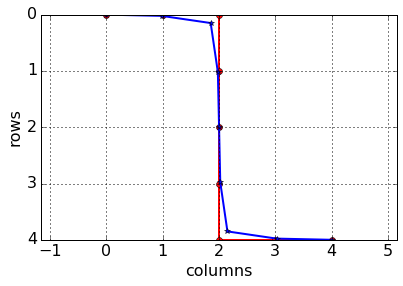

In [4]:
plot_paths(path,smooth(path,))

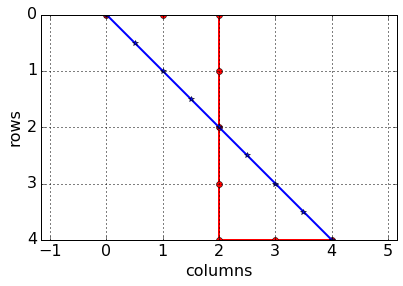

In [5]:
plot_paths(path,smooth(path,0,0.1))

## PID Control

In [6]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# Note that tau is called "param" in the function
# below.
#
# Your code should print output that looks like
# the output shown in the video. That is, at each step:
# print myrobot, steering
#

 
from math import *
import random


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)

    
# ------------------------------------------------------------------------
#
# run - does a single control run


def run(param1, param2 = 0.,param3 = 0., steering_drift = 0.,print_flag = False):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    myrobot.set_steering_drift(steering_drift)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    N = 100
    path_x = []
    path_y = []
    #
    time_interval = 1
    crosstrack_error = 0.
    crosstrack_error_int = 0.
    for i in range(N):
        path_x.append(myrobot.x)
        path_y.append(myrobot.y)
        crosstrack_error_old = crosstrack_error
        crosstrack_error = myrobot.y
        crosstrack_error_int += crosstrack_error
        crosstrack_error_der = (crosstrack_error - crosstrack_error_old) / float(time_interval)
        steering = -param1 * crosstrack_error - param2 * crosstrack_error_der - param3 * crosstrack_error_int
        myrobot = myrobot.move(steering, speed) 
        if print_flag:
            print myrobot, steering
    
    return path_x, path_y        
    # 

In [7]:
def plot_PID_response(x,y,label=''):    
    plt.plot(x, y, linewidth=4.0, linestyle = '-',label = label)
    plt.rcParams.update({'font.size': 16})
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('auto')
    plt.legend(loc='best', prop={'size':10})
    plt.title('Car Movement')

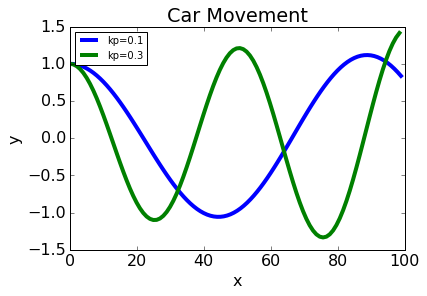

In [8]:
#Test
path_x, path_y = run(0.1,0.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'kp=0.1')
path_x, path_y = run(0.3,0.)
plot_PID_response(path_x,path_y,'kp=0.3')

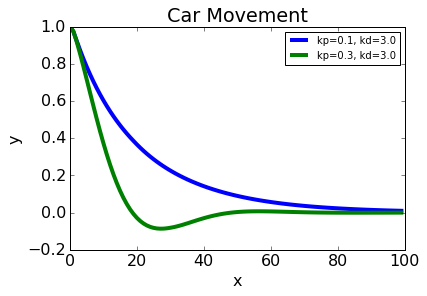

In [9]:
path_x, path_y = run(0.1,3.0) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'kp=0.1, kd=3.0')
path_x, path_y = run(0.3,3.0)
plot_PID_response(path_x,path_y,'kp=0.3, kd=3.0')

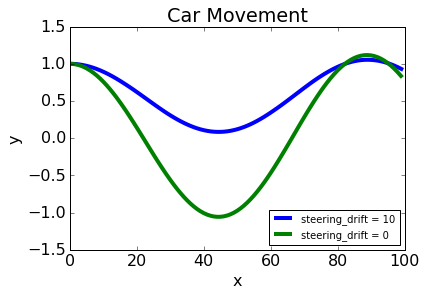

In [10]:
path_x, path_y = run(0.1,0.,0.,10/180.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 10')
path_x, path_y = run(0.1,0.,0.,0.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 0')

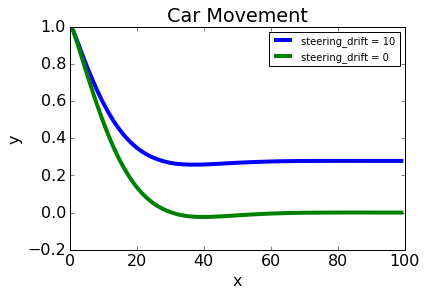

In [11]:
path_x, path_y = run(0.2,3.,0.,10/180.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 10')
path_x, path_y = run(0.2,3.,0.,0.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 0')

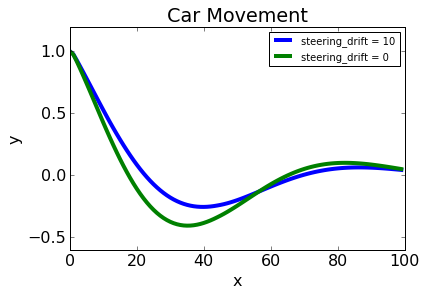

In [12]:
path_x, path_y = run(0.2,3.,0.01,10/180.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 10')
path_x, path_y = run(0.2,3.,0.01,0.) # call function with parameter tau of 0.1 and print results
plot_PID_response(path_x,path_y,'steering_drift = 0')

## PID Parameter Tuning - Twiddle

In [13]:
def run_return_error(params, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 1.0
    err = 0.0
    int_crosstrack_error = 0.0
    N = 100
    # myrobot.set_noise(0.1, 0.0)
    myrobot.set_steering_drift(10.0 / 180.0 * pi) # 10 degree steering error


    crosstrack_error = myrobot.y


    for i in range(N * 2):

        diff_crosstrack_error = myrobot.y - crosstrack_error
        crosstrack_error = myrobot.y
        int_crosstrack_error += crosstrack_error

        steer = - params[0] * crosstrack_error  \
            - params[1] * diff_crosstrack_error \
            - int_crosstrack_error * params[2]
        myrobot = myrobot.move(steer, speed)
        if i >= N:
            err += (crosstrack_error ** 2)
        if printflag:
            print myrobot, steer
    return err / float(N)


def twiddle(tol = 0.2): #Make this tolerance bigger if you are timing out!
    n_params = 3
    dparams = [1.0 for row in range(n_params)]
    params = [0.0 for row in range(n_params)]
    best_error = run_return_error(params)
    n = 0
    while sum(dparams) > tol:
        for i in range(len(params)):
            params[i] += dparams[i]
            err = run_return_error(params)
            if err < best_error:
                best_error = err
                dparams[i] *= 1.1
            else:
                params[i] -= 2.0 * dparams[i]
                err = run_return_error(params)
                if err < best_error:
                    best_error = err
                    dparams[i] *= 1.1
                else:
                    params[i] += dparams[i]
                    dparams[i] *= 0.9
    
        n += 1
        print 'Twiddle #', n, params, ' -> ', best_error
    return run_return_error(params)

In [14]:
twiddle()

Twiddle # 1 [1.0, 1.0, 0.0]  ->  0.0434970807257
Twiddle # 2 [1.0, 2.1, 0.0]  ->  0.0306543736244
Twiddle # 3 [1.9900000000000002, 3.3100000000000005, 0.0]  ->  0.00767732002007
Twiddle # 4 [3.0790000000000006, 4.641000000000001, 0.0]  ->  0.00322016742712
Twiddle # 5 [4.276900000000001, 4.641000000000002, 0.0]  ->  0.0016645945528
Twiddle # 6 [5.594590000000002, 5.9586900000000025, 0.0]  ->  0.000976108083168
Twiddle # 7 [7.044049000000003, 7.408149000000003, 0.0]  ->  0.000616343236777
Twiddle # 8 [8.638453900000004, 9.002553900000004, 0.0]  ->  0.000411027480544
Twiddle # 9 [8.638453900000002, 10.756399290000004, 0.43046721000000016]  ->  0.000198773741161
Twiddle # 10 [7.059993049000001, 12.685629219000006, 0.43046721000000016]  ->  1.17690259093e-06
Twiddle # 11 [5.323686112900001, 14.807782140900008, 0.43046721000000016]  ->  7.05088426932e-07
Twiddle # 12 [3.4137484831899996, 12.473413926810004, 0.43046721000000016]  ->  1.37973666889e-12
Twiddle # 13 [3.41374848319, 12.47341392

6.486248419977683e-16

# Cyclic Smoothing

In [15]:
# Homework

# -------------
# User Instructions
#
# Here you will be implementing a cyclic smoothing
# algorithm. This algorithm should not fix the end
# points (as you did in the unit quizzes). You  
# should use the gradient descent equations that
# you used previously.
#
# Your function should return the newpath that it
# calculates.
#
# Feel free to use the provided solution_check function
# to test your code. You can find it at the bottom.
#
# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with
# two arguments. The first argument should be the result of your
# smooth function. The second should be the corresponding answer.
# For example, calling
#
# solution_check(smooth(testpath1), answer1)
#
# should return True if your answer is correct and False if
# it is not.

from math import *

# Do not modify path inside your function.
path=[[0, 0], 
      [1, 0],
      [2, 0],
      [3, 0],
      [4, 0],
      [5, 0],
      [6, 0],
      [6, 1],
      [6, 2],
      [6, 3],
      [5, 3],
      [4, 3],
      [3, 3],
      [2, 3],
      [1, 3],
      [0, 3],
      [0, 2],
      [0, 1]]

############# ONLY ENTER CODE BELOW THIS LINE ##########

# ------------------------------------------------
# smooth coordinates
# If your code is timing out, make the tolerance parameter
# larger to decrease run time.
#

def cyclic_smooth(path, weight_data = 0.1, weight_smooth = 0.1, tolerance = 0.00001):

    newpath = deepcopy(path)

    change = tolerance    
    while change >= tolerance:
        change = 0
        for i in range(len(path)):
            for j in range(len(path[0])):
                oldpath = newpath[i][j]
                newpath[i][j] += weight_data * (path[i][j] - newpath[i][j]) +\
                                weight_smooth * (newpath[(i + 1) % len(path)][j] + newpath[(i-1) % len(path)][j] - 2 * newpath[i][j])
                change += abs(newpath[i][j] - oldpath)
    return newpath


##### TESTING ######

# --------------------------------------------------
# check if two numbers are 'close enough,'used in
# solution_check function.
#
def close_enough(user_answer, true_answer, epsilon = 0.001):
    if abs(user_answer - true_answer) > epsilon:
        return False
    return True

# --------------------------------------------------
# check your solution against our reference solution for
# a variety of test cases (given below)
#
def solution_check(newpath, answer):
    if type(newpath) != type(answer):
        print "Error. You do not return a list."
        return False
    if len(newpath) != len(answer):
        print 'Error. Your newpath is not the correct length.'
        return False
    if len(newpath[0]) != len(answer[0]):
        print 'Error. Your entries do not contain an (x, y) coordinate pair.'
        return False
    for i in range(len(newpath)): 
        for j in range(len(newpath[0])):
            if not close_enough(newpath[i][j], answer[i][j]):
                print 'Error, at least one of your entries is not correct.'
                return False
    print "Test case correct!"
    return True

In [16]:
# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with
# two arguments. The first argument should be the result of your
# smooth function. The second should be the corresponding answer.
# For example, calling
#
# solution_check(cyclic_smooth(testpath1), answer1)
#
# should return True if your answer is correct and False if
# it is not.
    
testpath1 = [[0, 0],
             [1, 0],
             [2, 0],
             [3, 0],
             [4, 0],
             [5, 0],
             [6, 0],
             [6, 1],
             [6, 2],
             [6, 3],
             [5, 3],
             [4, 3],
             [3, 3],
             [2, 3],
             [1, 3],
             [0, 3],
             [0, 2],
             [0, 1]]

answer1 = [[0.4705860385182691, 0.4235279620576893], 
           [1.1764695730296597, 0.16470408411716733], 
           [2.058823799247812, 0.07058633859438503], 
           [3.000001503542886, 0.04705708651959327], 
           [3.9411790099468273, 0.07058689299792453], 
           [4.8235326678889345, 0.16470511854183797], 
           [5.529415336860586, 0.4235293374365447], 
           [5.76470933698621, 1.1058829941330384], 
           [5.764708805535902, 1.8941189433780983], 
           [5.5294138118186265, 2.5764724018811056], 
           [4.823530348360371, 2.835296251305122], 
           [3.941176199414957, 2.929413985845729],
           [2.9999985709076413, 2.952943245204772], 
           [2.0588211310939526, 2.9294134622132018], 
           [1.1764675231284938, 2.8352952720424938], 
           [0.4705848811030855, 2.5764710948028178], 
           [0.23529088056307781, 1.8941174802285707], 
           [0.23529138316655338, 1.1058815684272394]]

testpath2 = [[1, 0], # Move in the shape of a plus sign
             [2, 0],
             [2, 1],
             [3, 1],
             [3, 2],
             [2, 2],
             [2, 3],
             [1, 3],
             [1, 2],
             [0, 2], 
             [0, 1],
             [1, 1]]

answer2 = [[1.2222234770374059, 0.4444422843711052],
           [1.7777807251383388, 0.4444432993123497], 
           [2.111114925633848, 0.8888894279539462], 
           [2.5555592020540376, 1.2222246475393077], 
           [2.5555580686154244, 1.7777817817879298], 
           [2.111111849558437, 2.1111159707965514], 
           [1.7777765871460525, 2.55556033483712], 
           [1.2222194640861452, 2.5555593592828543], 
           [0.8888853322565222, 2.111113321684573], 
           [0.44444105139827167, 1.777778212019149], 
           [0.44444210978390364, 1.2222211690821811], 
           [0.8888882042812255, 0.8888870211766268]]

solution_check(cyclic_smooth(testpath1), answer1)
#solution_check(cyclic_smooth(testpath2), answer2)

Test case correct!


True

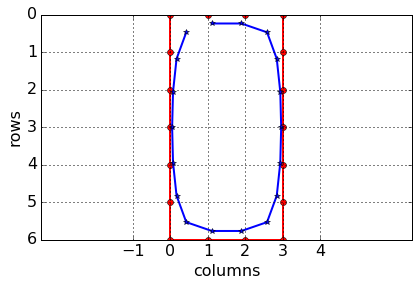

In [17]:
plot_paths(testpath1,cyclic_smooth(testpath1))

# Constrained Smoothing

In [18]:
# -------------
# User Instructions
#
# Now you will be incorporating fixed points into
# your smoother. 
#
# You will need to use the equations from gradient
# descent AND the new equations presented in the
# previous lecture to implement smoothing with
# fixed points.
#
# Your function should return the newpath that it
# calculates. 
#
# Feel free to use the provided solution_check function
# to test your code. You can find it at the bottom.
#

######################## ENTER CODE BELOW HERE #########################

def constrained_smooth(path, fix, weight_data = 0.0, weight_smooth = 0.1, tolerance = 0.00001):
    newpath = deepcopy(path)

    change = tolerance    
    while change >= tolerance:
        change = 0
        for i in range(len(path)):
            if not fix[i]:
                for j in range(len(path[0])):
                    oldpath = newpath[i][j]
                    newpath[i][j] += weight_data * (path[i][j] - newpath[i][j])
                    newpath[i][j] += weight_smooth * (newpath[(i + 1) % len(path)][j] + \
                                                      newpath[(i-1) % len(path)][j] - 2 * newpath[i][j]) +\
                                     weight_smooth / 2.0 * (2 * newpath[(i - 1) % len(path)][j] - \
                                                            newpath[(i-2) % len(path)][j] - newpath[i][j]) +\
                                     weight_smooth / 2.0 * (2 * newpath[(i + 1) % len(path)][j] - \
                                                            newpath[(i+2) % len(path)][j] - newpath[i][j])
                    change += abs(newpath[i][j] - oldpath)
    return newpath

# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with the argument smooth:
# solution_check(smooth)
#

def solution_check(smooth, eps = 0.0001):
    
    def test_case_str(path, fix):
        assert( len(path) == len(fix) )

        if len(path) == 0:
            return '[]'
        if len(path) == 1:
            s = '[' + str(path[0]) + ']'
            if fix[0]: s += ' #fix'
            return s

        s = '[' + str(path[0]) + ','
        if fix[0]: s += ' #fix'
        for pt,f in zip(path[1:-1],fix[1:-1]):
            s += '\n ' + str(pt) + ','
            if f: s += ' #fix'
        s += '\n ' + str(path[-1]) + ']'
        if fix[-1]: s += ' #fix'
        return s
    
    testpaths = [[[0, 0],[1, 0],[2, 0],[3, 0],[4, 0],[5, 0],[6, 0],[6, 1],[6, 2],[6, 3],
                  [5, 3],[4, 3],[3, 3],[2, 3],[1, 3],[0, 3],[0, 2],[0, 1]],
                 [[0, 0],[2, 0],[4, 0],[4, 2],[4, 4],[2, 4],[0, 4],[0, 2]]]
    testfixpts = [[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
                  [1, 0, 1, 0, 1, 0, 1, 0]]
    pseudo_answers = [[[0, 0],
                       [0.7938620981547201, -0.8311168821106101],
                       [1.8579052986461084, -1.3834788165869276],
                       [3.053905318597796, -1.5745863173084],
                       [4.23141390533387, -1.3784271816058231],
                       [5.250184859723701, -0.8264215958231558],
                       [6, 0],
                       [6.415150091996651, 0.9836951698796843],
                       [6.41942442687092, 2.019512290770163],
                       [6, 3],
                       [5.206131365604606, 3.831104483245191],
                       [4.142082497497067, 4.383455704596517],
                       [2.9460804122779813, 4.5745592975708105],
                       [1.768574219397359, 4.378404668718541],
                       [0.7498089205417316, 3.826409771585794],
                       [0, 3],
                       [-0.4151464728194156, 2.016311854977891],
                       [-0.4194207879552198, 0.9804948340550833]],
                      [[0, 0],
                       [2.0116767115496095, -0.7015439080661671],
                       [4, 0],
                       [4.701543905420104, 2.0116768147460418],
                       [4, 4],
                       [1.9883231877640861, 4.701543807525115],
                       [0, 4],
                       [-0.7015438099112995, 1.9883232808252207]]]
    true_answers = [[[0, 0],
                     [0.7826068175979299, -0.6922616156406778],
                     [1.826083356960912, -1.107599209206985],
                     [2.999995745732953, -1.2460426422963626],
                     [4.173909508264126, -1.1076018591282746],
                     [5.217389489606966, -0.6922642758483151],
                     [6, 0],
                     [6.391305105067843, 0.969228211275216],
                     [6.391305001845138, 2.0307762911524616],
                     [6, 3],
                     [5.217390488523538, 3.6922567975830876],
                     [4.17391158149052, 4.107590195596796],
                     [2.9999982969959467, 4.246032043344827],
                     [1.8260854997325473, 4.107592961155283],
                     [0.7826078838205919, 3.692259569132191],
                     [0, 3],
                     [-0.3913036785959153, 2.030774470796648], 
                     [-0.3913035729270973, 0.9692264531461132]],
                    [[0, 0],
                     [1.9999953708444873, -0.6666702980585777],
                     [4, 0],
                     [4.666670298058577, 2.000005101453379],
                     [4, 4],
                     [1.9999948985466212, 4.6666612524128],
                     [0, 4],
                     [-0.6666612524127998, 2.000003692691148]]]
    newpaths = map(lambda p: smooth(*p), zip(testpaths,testfixpts))
    
    correct = True
    
    for path,fix,p_answer,t_answer,newpath in zip(testpaths,testfixpts,
                                                   pseudo_answers,true_answers,
                                                   newpaths):
        if type(newpath) != list:
            print "Error: smooth did not return a list for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue
        if len(newpath) != len(path):
            print "Error: smooth did not return a list of the correct length for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue

        good_pairs = True
        for newpt,pt in zip(newpath,path): 
            if len(newpt) != len(pt):
                good_pairs = False
                break
        if not good_pairs:
            print "Error: smooth did not return a list of coordinate pairs for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue
        assert( good_pairs )
        
        # check whether to check against true or pseudo answers
        answer = None
        if abs(newpath[1][0] - t_answer[1][0]) <= eps:
            answer = t_answer
        elif abs(newpath[1][0] - p_answer[1][0]) <= eps:
            answer = p_answer
        else:
            print 'smooth returned an incorrect answer for the path:'
            print test_case_str(path,fix) + '\n'
            continue
        assert( answer is not None )

        entries_match = True
        for p,q in zip(newpath,answer):
            for pi,qi in zip(p,q):
                if abs(pi - qi) > eps:
                    entries_match = False
                    break
            if not entries_match: break
        if not entries_match:
            print 'smooth returned an incorrect answer for the path:'
            print test_case_str(path,fix) + '\n'
            continue
            
        assert( entries_match )
        if answer == t_answer:
            print 'smooth returned the correct answer for the path:'
            print test_case_str(path,fix) + '\n'
        elif answer == p_answer:
            print 'smooth returned a correct* answer for the path:'
            print test_case_str(path,fix)
            print '''*However, your answer uses the "nonsimultaneous" update method, which
is not technically correct. You should modify your code so that newpath[i][j] is only 
updated once per iteration, or else the intermediate updates made to newpath[i][j]
will affect the final answer.\n'''

solution_check(constrained_smooth)

smooth returned the correct answer for the path:
[[0, 0], #fix
 [1, 0],
 [2, 0],
 [3, 0],
 [4, 0],
 [5, 0],
 [6, 0], #fix
 [6, 1],
 [6, 2],
 [6, 3], #fix
 [5, 3],
 [4, 3],
 [3, 3],
 [2, 3],
 [1, 3],
 [0, 3], #fix
 [0, 2],
 [0, 1]]

smooth returned the correct answer for the path:
[[0, 0], #fix
 [2, 0],
 [4, 0], #fix
 [4, 2],
 [4, 4], #fix
 [2, 4],
 [0, 4], #fix
 [0, 2]]



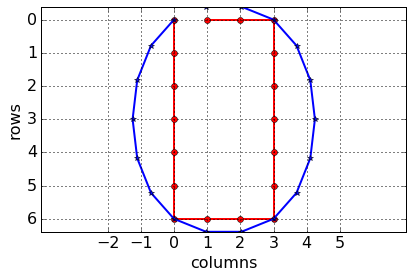

In [19]:
testpaths = [[0, 0],[1, 0],[2, 0],[3, 0],[4, 0],[5, 0],[6, 0],[6, 1],[6, 2],[6, 3],
                  [5, 3],[4, 3],[3, 3],[2, 3],[1, 3],[0, 3],[0, 2],[0, 1]]
fix=[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
plot_paths(testpaths,constrained_smooth(testpaths,fix))

# Racetrack Control

In [20]:
# --------------
# User Instructions
# 
# Define a function cte in the robot class that will
# compute the crosstrack error for a robot on a
# racetrack with a shape as described in the video.
#
# You will need to base your error calculation on
# the robot's location on the track. Remember that 
# the robot will be traveling to the right on the
# upper straight segment and to the left on the lower
# straight segment.
#
# --------------
# Grading Notes
#
# We will be testing your cte function directly by
# calling it with different robot locations and making
# sure that it returns the correct crosstrack error.  
 
from math import *
import random


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res




    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)

   
    def cte(self, radius):
        # 
        #
        x = self.x
        y = self.y
        cte = 0
        if x <= radius:
            cte = sqrt((x - radius) ** 2 + (y - radius) ** 2) - radius
        elif x >= 3 * radius:
            cte = sqrt((x - 3 * radius) ** 2 + (y - radius) ** 2) - radius
        elif y > radius:
            cte = y - 2 * radius
        else:
            cte = -y
        #
        #            
        return cte
    




# ------------------------------------------------------------------------
#
# run - does a single control run.


def racetrack_run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N = 200

    crosstrack_error = myrobot.cte(radius) # You need to define the cte function!
    x = []
    y = []
    for i in range(N*2):
        # PID control
        x.append(myrobot.x)
        y.append(myrobot.y)
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = - params[0] * crosstrack_error \
                - params[1] * diff_crosstrack_error \
                - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)
        if i >= N:
            err += crosstrack_error ** 2
        if printflag:
            print myrobot
    plot_PID_response(x,y,'RaceTrack')
    return err / float(N)


Final parameters:  [10.0, 15.0, 0] 
 -> 0.00586850481282


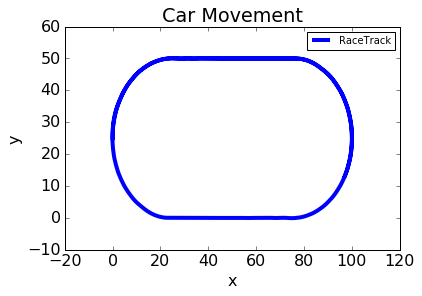

In [21]:
radius = 25.0
params = [10.0, 15.0, 0]
err = racetrack_run(params, radius, False)
print '\nFinal parameters: ', params, '\n ->', err